In [26]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [27]:
import datetime
import json
import pathlib

import pandas as pd
import numpy as np
import toolz
from IPython.display import Image, HTML

In [28]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, onmt_model_2
reload(analysis_util), reload(util), reload(notebook_util), reload(onmt_model_2)

Loading COCO captions
Loading COCO id2url
Done
Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.


(<module 'textrec.analysis_util' from '/Users/kcarnold/code/textrec/src/textrec/analysis_util.py'>,
 <module 'textrec.util' from '/Users/kcarnold/code/textrec/src/textrec/util.py'>,
 <module 'textrec.notebook_util' from '/Users/kcarnold/code/textrec/src/textrec/notebook_util.py'>,
 <module 'textrec.onmt_model_2' from '/Users/kcarnold/code/textrec/src/textrec/onmt_model_2.py'>)

In [60]:
{k: len(v) for k, v in notebook_util.images_by_split.items()}

{'test': 5000, 'restval': 30504, 'val': 5000, 'train': 82783}

In [29]:
paths.imgdata_h5 = paths.imgdata_h5_all

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
img = notebook_util.images_by_split['train'][0]
print(img['cocoid'])
img_captions = [sent['tokens'] for sent in img['sentences']]
print('\n'.join(' '.join(toks) for toks in img_captions))

57870
a restaurant has modern wooden tables and chairs
a long restaurant table with rattan rounded back chairs
a long table with a plant on top of it surrounded with wooden chairs
a long table with a flower arrangement in the middle for meetings
a table is adorned with wooden chairs with blue accents


In [7]:
onmt_model_2.get_recs('coco_cap', str(img['cocoid']), [])

[('a', -0.19775964319705963),
 ('man', -3.1341943740844727),
 ('the', -3.242462158203125)]

In [8]:
onmt_model_2.get_recs('coco_lm', '.', [])

[('a', -0.4023953676223755),
 ('two', -2.944744110107422),
 ('the', -2.9826602935791016)]

Word-at-a-time ROC curve. TODO: character-at-a-time?

In [9]:
import random

In [10]:
import tqdm

In [56]:
def collect_classifier_data(rs, images, n, get_recs):
    contexts = []
    feats = []
    y = []
    for i in tqdm.tqdm_notebook(range(n)):
        img_idx = rs.choice(len(images))
        img = images[img_idx]
        sents = img['sentences']
        sent_idx = rs.choice(len(sents))
        sent = sents[sent_idx]
        toks = sent['tokens']
        tok_idx = rs.choice(len(toks))
        true_word = toks[tok_idx]
        context = toks[:tok_idx]
        recs = get_recs(img, context)
        probs = [prob for word, prob in recs]

        contexts.append(dict(
            img_idx=img_idx, sent_idx=sent_idx, tok_idx=tok_idx))
        feats.append([
            max(probs),
            np.mean(probs),
            min(probs)
        ])
        y.append(true_word in [word for word, prob in recs])
    return contexts, feats, y

def get_recs_cap(img, context): return onmt_model_2.get_recs('coco_cap', str(img['cocoid']), context)
def get_recs_lm(img, context): return onmt_model_2.get_recs('coco_lm', '.', context)

contexts, feats, y = collect_classifier_data(np.random.RandomState(0), notebook_util.images_by_split['val'], 1000, get_recs_cap)

In [57]:
contexts_lm, feats_lm, y_lm = collect_classifier_data(np.random.RandomState(0), notebook_util.images_by_split['val'], 1000, get_recs_lm)

In [69]:
def label_feats(feats):
    return dict(zip('max mean min'.split(), np.array(feats).T))

In [58]:
from sklearn.metrics import roc_curve, auc

In [70]:
def get_rocs(labeled_feats):
    return {
        k: dict(zip('fpr tpr thresholds'.split(), roc_curve(y, v)))
        for k, v in labeled_feats.items()
    }

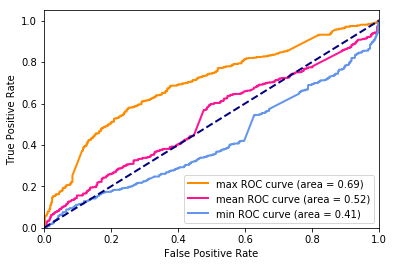

In [71]:
def plot_rocs(feats, y):
    rocs = get_rocs(label_feats(feats))
    aucs = {k: auc(roc['fpr'], roc['tpr']) for k, roc in rocs.items()}

    lw = 2
    for name, color in [('max', 'darkorange'), ('mean', 'deeppink'), ('min', 'cornflowerblue')]:
        roc = rocs[name]
        plt.plot(roc['fpr'], roc['tpr'], color=color,
                 lw=lw, label=f'{name} ROC curve (area = {aucs[name]:.02f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    return rocs
rocs = plot_rocs(feats_lm, y_lm)

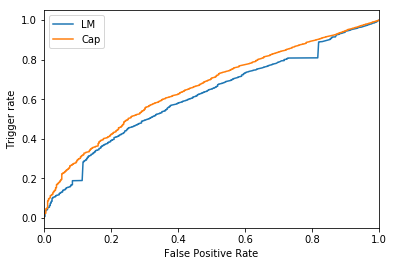

In [72]:
def compute_display_rate(feats, y):
    labeled_feats = label_feats(feats)
    rocs = get_rocs(labeled_feats)
    def get_rate(feats, threshold):
        return np.mean(feats > threshold)
    rates = [get_rate(labeled_feats['max'], threshold) for threshold in rocs['max']['thresholds']]
    rates = np.mean(labeled_feats['max'][:,None] > rocs['max']['thresholds'][None,:], axis=0)
    return rocs['max']['fpr'], rates

plt.plot(*compute_display_rate(feats_lm, y_lm), label="LM")
plt.plot(*compute_display_rate(feats, y), label="Cap")

plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('Trigger rate')
plt.legend();

In [63]:
fpr, trigger_rate = compute_display_rate(feats_lm, y_lm)

In [ ]:
scipy.interp([.5], trigger_rate, rocs['max']['thresholds'])

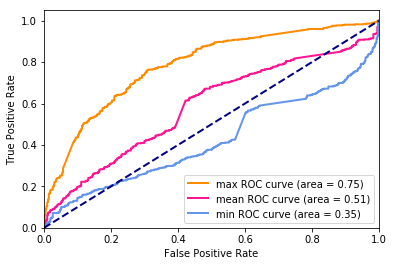

In [62]:
lw = 2
for name, color in [('max', 'darkorange'), ('mean', 'deeppink'), ('min', 'cornflowerblue')]:
    roc = rocs[name]
    plt.plot(roc['fpr'], roc['tpr'], color=color,
             lw=lw, label=f'{name} ROC curve (area = {aucs[name]:.02f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")


We should definitely use the max value as the threshold.

In [64]:
import scipy

In [54]:
scipy.interp([.1, .9], rocs['max']['fpr'], rocs['max']['thresholds'])

array([-0.45656539, -2.12771965])